<a href="https://colab.research.google.com/github/ngabo-dev/sentiment-analysis_group3/blob/main/diana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
# -----------------------------
# 1️⃣ Import Libraries
# -----------------------------
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib


In [18]:
# -----------------------------
# 2️⃣ Load Data
# -----------------------------
df = pd.read_csv("processed_dataset.csv")
print("Dataset loaded:", df.shape)
print(df.head())

Dataset loaded: (71204, 3)
                                                text  \
0  This is by far my favorite K cup. It is a stro...   
1  OK, I am now READDICTED to SUGAR!  This stuff ...   
2  I don't understand how anyone with a pair of t...   
3  a favorite.....Tetley tea's British decaffeina...   
4  Something about the flavor just isn't right.  ...   

                                                proc  label  
0  far favorite cup strong flavorful harsh coffee...      1  
1  readdicted sugar stuff much much better silk c...      1  
2  understand anyone pair taste bud rub together ...      0  
3  favorite tetley tea british decaffeinated blen...      1  
4  something flavor right purchased consumed lot ...      0  


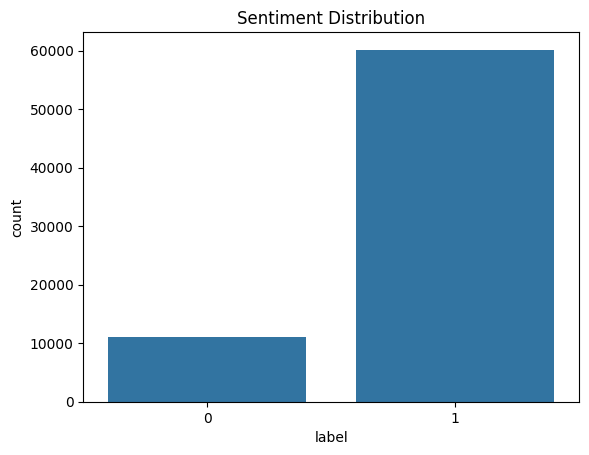

In [22]:
# -----------------------------
# 3️⃣ EDA
# -----------------------------
# Distribution of labels

sns.countplot(x='label', data=df)
plt.title("Sentiment Distribution")
plt.show()


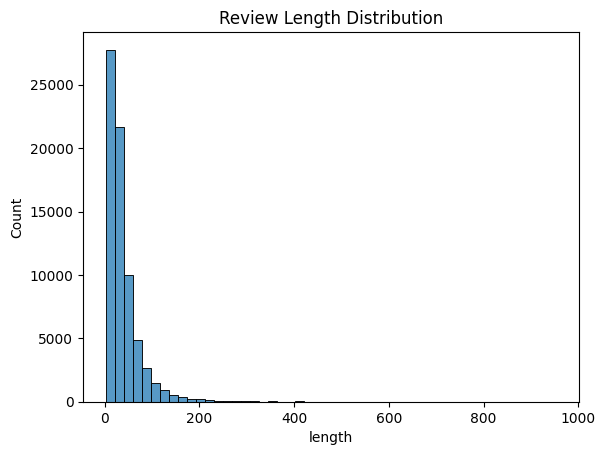

In [23]:
# Review length distribution
df['length'] = df['proc'].apply(lambda x: len(x.split()))
sns.histplot(df['length'], bins=50)
plt.title("Review Length Distribution")
plt.show()

In [24]:
# -----------------------------
# 4️⃣ Split Data
# -----------------------------
X = df['proc'].values
y = df['label'].values


# Stratified split: train/val/test
X_temp, X_test, y_temp, y_test = train_test_split(
X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
X_temp, y_temp, test_size=0.1, stratify=y_temp, random_state=42
)
print("Train/Val/Test sizes:", len(X_train), len(X_val), len(X_test))


Train/Val/Test sizes: 51266 5697 14241


In [25]:
# -----------------------------
# 5️⃣ TF-IDF Features (for SVM)
# -----------------------------
tfidf_vect = TfidfVectorizer(max_features=30000, ngram_range=(1,2), min_df=2, max_df=0.98)
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_val_tfidf = tfidf_vect.transform(X_val)
X_test_tfidf = tfidf_vect.transform(X_test)

print("TF-IDF shapes:", X_train_tfidf.shape, X_val_tfidf.shape, X_test_tfidf.shape)

TF-IDF shapes: (51266, 30000) (5697, 30000) (14241, 30000)



Training SVM with kernel=linear, C=1.0...
Validation Accuracy: 0.9300

Training SVM with kernel=linear, C=0.5...
Validation Accuracy: 0.9256

Training SVM with kernel=rbf, C=1.0...
Validation Accuracy: 0.9282

Training SVM with kernel=rbf, C=0.5...
Validation Accuracy: 0.9124

SVM Experiment Results:
   kernel    C  val_accuracy
0  linear  1.0      0.929963
1  linear  0.5      0.925575
2     rbf  1.0      0.928208
3     rbf  0.5      0.912410

Training Best Model (Linear SVM, C=1.0)

SVM Test Accuracy: 0.9324485640053367

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.67      0.76      2209
           1       0.94      0.98      0.96     12032

    accuracy                           0.93     14241
   macro avg       0.90      0.83      0.86     14241
weighted avg       0.93      0.93      0.93     14241



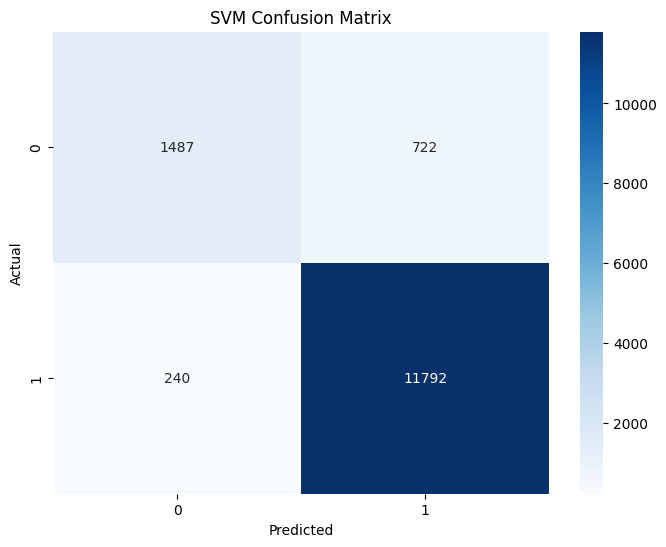


Analysis Complete!


In [26]:
# -----------------------------
# 6️⃣ Traditional ML: SVM
# -----------------------------
# Experiment table: different kernels & C
svm_experiments = [
    {'kernel': 'linear', 'C': 1.0},
    {'kernel': 'linear', 'C': 0.5},
    {'kernel': 'rbf', 'C': 1.0},
    {'kernel': 'rbf', 'C': 0.5},
]

svm_results = []

for exp in svm_experiments:
    print(f"\nTraining SVM with kernel={exp['kernel']}, C={exp['C']}...")
    svm = SVC(kernel=exp['kernel'], C=exp['C'], random_state=42)
    svm.fit(X_train_tfidf, y_train)
    y_val_pred = svm.predict(X_val_tfidf)
    acc = accuracy_score(y_val, y_val_pred)
    svm_results.append({
        'kernel': exp['kernel'],
        'C': exp['C'],
        'val_accuracy': acc
    })
    print(f"Validation Accuracy: {acc:.4f}")

# Display experiment results
df_svm_results = pd.DataFrame(svm_results)
print("\n" + "="*50)
print("SVM Experiment Results:")
print("="*50)
print(df_svm_results)

# Best SVM on test set
print("\n" + "="*50)
print("Training Best Model (Linear SVM, C=1.0)")
print("="*50)
best_svm = SVC(kernel='linear', C=1.0, random_state=42)
best_svm.fit(X_train_tfidf, y_train)
y_test_pred_svm = best_svm.predict(X_test_tfidf)
print("\nSVM Test Accuracy:", accuracy_score(y_test, y_test_pred_svm))
print("\nSVM Classification Report:")
print(classification_report(y_test, y_test_pred_svm))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\n" + "="*50)
print("Analysis Complete!")
print("="*50)

In [38]:
# -------------------
# 7️⃣ Save the Model
# -------------------
print("\n" + "="*50)
print("Saving Model and Vectorizer")
print("="*50)

# Create models directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Save the trained SVM model with name "svm"
joblib.dump(best_svm, 'models/svm.pkl')
print("✓ SVM model saved as 'models/svm.pkl'")


Saving Model and Vectorizer
✓ SVM model saved as 'models/svm.pkl'
